In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

In [3]:
class contrast_streaching:
    def __init__(self):
        
        self.max_o = 255        # maximum pixel value for output image
        self.min_o = 0          # minimum pixel value for output image
        self.min_red_i = 86     # minimum red pixel value for output image
        self.max_red_i = 230    # maximum red pixel value for output image
        self.min_green_i = 90   # minimum green pixel value for output image
        self.max_green_i = 225  # maximum green pixel value for output image
        # 100
        self.min_blue_i = 120   # minimum blue pixel value for output image
        # 210
        self.max_blue_i = 225   # maximum blue pixel value for output image
    
    # to normalize the red function
    def _normalizeRed(self, intensity):
        i = intensity
        i_output = (i-self.min_red_i)*(((self.max_o-self.min_o)/(self.max_red_i-self.min_red_i))+self.min_o)
        return i_output
    
    # to normalize the green function
    def _normalizeGreen(self, intensity):
        i = intensity
        i_output = (i-self.min_green_i)*(((self.max_o-self.min_o)/(self.max_green_i-self.min_green_i))+self.min_o)
        return i_output

    # to normalize the red function
    def _normalizeBlue(self, intensity):
        i = intensity
        i_output = (i-self.min_blue_i)*(((self.max_o-self.min_o)/(self.max_blue_i-self.min_blue_i))+self.min_o)
        return i_output
    
    def get_normalizeValue(self,path):
        
        # Create an image object
        imageObject     = Image.open(path)  # provide image path

        # Split the red, green and blue bands from the Image
        multiBands      = imageObject.split()

        # Apply point operations that does contrast stretching on each color band
        normalizedRedBand      = multiBands[0].point(self._normalizeRed)
        normalizedGreenBand    = multiBands[1].point(self._normalizeGreen)
        normalizedBlueBand     = multiBands[2].point(self._normalizeBlue)

        # Create a new image from the contrast stretched red, green and blue brands
        normalizedImage = Image.merge("RGB", (normalizedRedBand, normalizedGreenBand, normalizedBlueBand)) 
        return normalizedImage

# color of colon cancer is blue and lung cancer is white

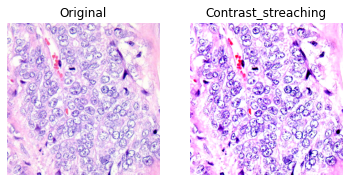

In [4]:
# test the contrast straching
# image path
path="../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg"

# create object
test = contrast_streaching()

# original image
imageObject = Image.open(path)

# image after contrast streaching
normalizedImage = test.get_normalizeValue(path)

# plot
plt.figure(figsize=(6, 6)) 
test = contrast_streaching()


plt.subplot(1, 2,1)
plt.title("Original")
plt.imshow(imageObject)
plt.axis('off')

plt.subplot(1, 2,2)
plt.title("Contrast_streaching")
plt.imshow(normalizedImage)

plt.axis('off')
plt.show()

In [5]:
# Copying the folders into a single folder
PATH=["./LungColon","./LungColon/colon_aca","./LungColon/colon_n","./LungColon/lung_aca",
      "./LungColon/lung_n", "./LungColon/lung_scc"]
for path in PATH:
    try:
        os.mkdir(path)
    except:
        print("folders may already exist")

test = contrast_streaching()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        save_dir = dirname.split("/")[-1]
        path = os.path.join(dirname, filename)
        result = test.get_normalizeValue(path)
        save_path="LungColon/"+save_dir+"/"+filename
        result.save(save_path)

In [6]:
folders = glob('./LungColon' + '/*')
print('New Paths: ', folders)

IMAGE_FILES = glob('./LungColon' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))

New Paths:  ['./LungColon/lung_n', './LungColon/lung_aca', './LungColon/colon_n', './LungColon/lung_scc', './LungColon/colon_aca']
Images Count:  25000


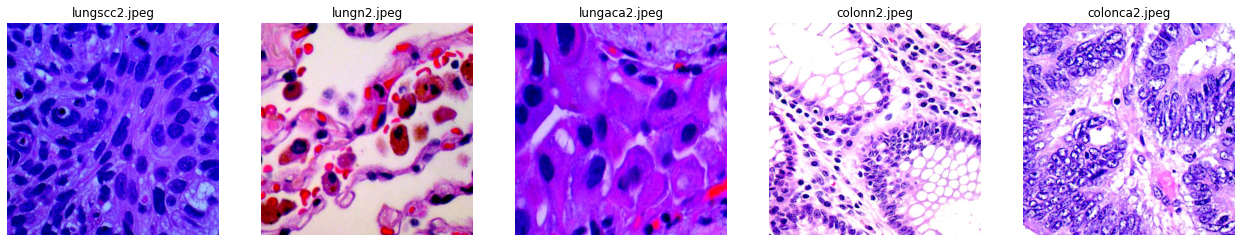

In [7]:
SAMPLES = ['./LungColon/lung_scc/lungscc2.jpeg', './LungColon/lung_n/lungn2.jpeg', 
           './LungColon/lung_aca/lungaca2.jpeg', './LungColon/colon_n/colonn2.jpeg', 
           './LungColon/colon_aca/colonca2.jpeg']

plt.figure(figsize=(22, 8)) 
global c
c = 0
test = contrast_streaching()

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.title(t[3])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

In [8]:
data_dir = './LungColon'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 300

training = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [9]:
ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='imagenet',
    include_top=False)

ptm.trainable = False

K = len(folders)

x = GlobalAveragePooling2D()(ptm.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

y = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=y)
#model.summary()

2022-09-13 11:38:30.687221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 11:38:30.853073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 11:38:30.853982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 11:38:30.855435: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

258088960/258076736 [==============================] - 2s 0us/step


In [10]:
#model.summary()

In [11]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    training,
    validation_data=validation,
    epochs=50,
    callbacks=[early_stopping])

2022-09-13 11:38:42.643770: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-09-13 11:39:01.935360: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 406s 2s/step - loss: 0.8517 - accuracy: 0.7149 - val_loss: 0.2925 - val_accuracy: 0.9072
Epoch 2/50
157/157 [==============================] - 375s 2s/step - loss: 0.2541 - accuracy: 0.9134 - val_loss: 0.1459 - val_accuracy: 0.9514
Epoch 3/50
157/157 [==============================] - 376s 2s/step - loss: 0.1682 - accuracy: 0.9403 - val_loss: 0.1203 - val_accuracy: 0.9554
Epoch 4/50
157/157 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9481

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()

In [ ]:
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=False,
                      title='Confusion Matrix')
plt.show()